# Using the Leja et al. (2019) continuity non-parametric SFH model

I've finally got round to implementing the [Leja et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...876....3L/abstract) continuity non-parametric SFH model in Bagpipes. This notebook should explain how to build models and run fits using this SFH.

## Setting up

Let's begin by running a quick new fit to the same object from GOODSS that we used in Example 4.

In [1]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits

def load_goodss(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                              11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :15]
    fluxerrs = cat[row, 15:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry


goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str").tolist()

galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list)

# Now make a basic fit instructions dictionary.

dust = {}
dust["type"] = "Calzetti"
dust["eta"] = 2.
dust["Av"] = (0., 4.)

nebular = {}
nebular["logU"] = -3.

fit_instructions = {}
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular
fit_instructions["t_bc"] = 0.01
fit_instructions["redshift"] = 1.05


Starting dense_basis. Failed to load FSPS, only GP-SFH module will be available.


## The continuity model

Now for the continuity SFH component. You'll need to define your own age bin edges - these are counted in Myr backwards from the time of observation. You'll also need to set up fitted parameters called "dsfr1", "dsfr2", etc, which have associated Student's t distribution priors. The range from (-10, 10) is just an arbitrarily large range over which these can vary.

I haven't yet got round to doing anything about bin resizing when redshift changes, so using this model whilst varying redshift freely won't work (i.e. you'll get an error if you define a bin that starts before the Big Bang). For fixed redshift or redshift varied within a narrow range (e.g. when fitting spectroscopy) the current setup should be fine. I can have a go at implementing bins that vary in width with redshift if this would be useful.

In [2]:

continuity = {}
continuity["massformed"] = (0., 13.)
continuity["metallicity"] = (0.01, 5.)
continuity["metallicity_prior"] = "log_10"
continuity["bin_edges"] = [0., 10., 100., 250., 500.,
                           1000., 2500., 5000., 5500.]

for i in range(1, len(continuity["bin_edges"])-1):
    continuity["dsfr" + str(i)] = (-10., 10.)
    continuity["dsfr" + str(i) + "_prior"] = "student_t"
    #continuity["dsfr" + str(i) + "_prior_scale"] = 0.3  # Defaults to this value as in Leja19, but can be set
    #continuity["dsfr" + str(i) + "_prior_df"] = 2       # Defaults to this value as in Leja19, but can be set

fit_instructions["continuity"] = continuity



Bagpipes: fitting object 17433


Completed in 325.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
continuity:dsfr1              -0.340     -0.029      0.294
continuity:dsfr2              -0.158      0.098      0.450
continuity:dsfr3              -0.183      0.040      0.236
continuity:dsfr4              -0.728     -0.337     -0.147
continuity:dsfr5              -3.903     -2.045     -0.859
continuity:dsfr6              -0.991     -0.292      0.026
continuity:dsfr7              -0.664     -0.191      0.099
continuity:massformed         11.226     11.263     11.305
continuity:metallicity         0.538      0.936      1.385
dust:Av                        0.252      0.380      0.543




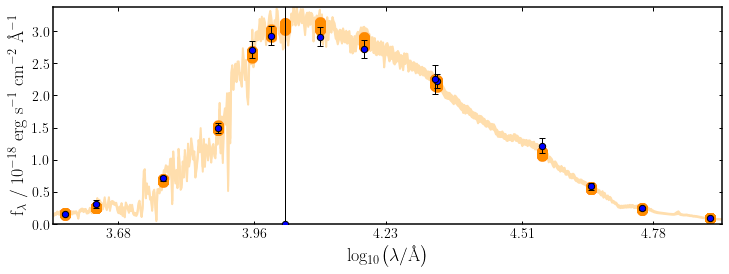

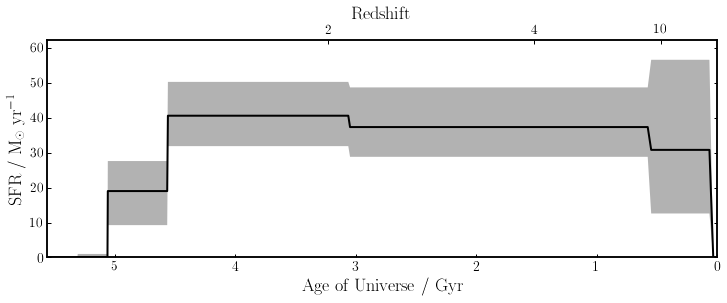

In [3]:
fit = pipes.fit(galaxy, fit_instructions, run="advanced_2")

fit.fit(verbose=False)

fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)